In [10]:
import pandas as pd
import ast
import random
import time
import seaborn as sns
import copy

In [2]:
random.seed(16)
# random.seed(17)
# random.seed(18)

## Import data

In [3]:
job_shop_df = pd.read_csv('job_shop_data.csv', sep=';', index_col=False)
job_shop_df['problem_instance'] = job_shop_df['problem_instance'].apply(lambda x: ast.literal_eval(x))

In [4]:
job_shop_df.head()

,instance_id,num_jobs,num_machines,problem_instance
0,5j5m,5,5,"[[(3, 6), (1, 4), (2, 1), (0, 3), (4, 6)], [(0..."
1,5j6m,5,6,"[[(5, 9), (3, 5), (0, 7), (2, 2), (1, 2), (4, ..."
2,5j7m,5,7,"[[(5, 7), (6, 3), (3, 4), (1, 1), (2, 4), (4, ..."
3,5j8m,5,8,"[[(1, 7), (3, 9), (6, 3), (0, 8), (2, 1), (7, ..."
4,5j9m,5,9,"[[(7, 6), (4, 10), (8, 1), (2, 2), (1, 10), (5..."


## Functions to build up the HillClimber and FFA-HillClimber algorithms

In [5]:
def random_solution_permutation_representation(problem_instance):
    num_jobs = len(problem_instance)
    num_machines = len(problem_instance[0])
    solution = [job for job in range(num_jobs) for i in range(num_machines)]
    random.shuffle(solution)
    return solution


def permutation_to_makespan(permutation_rep, problem_instance):
    makespan = 0
    current_time = 0
    num_jobs = len(problem_instance)
    num_machines = len(problem_instance[0])
    
    # keeps track of the number of times that a job has already occured
    job_count = [0 for job in range(num_jobs)]
    
    # keep track of the current end time of each job
    jobs_end_time = [0 for job in range(num_jobs)]
    
    # keep track of the current end time of each machine
    machines_end_time = [0 for machine in range(num_machines)]
    
    for job in permutation_rep:

        job_list = problem_instance[job] #gives the list of a job in which we find the sequence of machines and the processing times on those machines
        job_index = job_count[job] #to find the index at which the relevant machine number and processing time info is stored

        machine = job_list[job_index][0] #the machine that this job should be processed on now
        processing_time = job_list[job_index][1] #the relevant processing time
        
        
        # increase job occurrence for next iterations
        job_count[job] += 1
        
        # the job can start on this machine when both this job and this machine have finished their last run
        job_machine_end_time = max(jobs_end_time[job], machines_end_time[machine])
        new_end_time = job_machine_end_time + processing_time #add current processing time to the previous end time
        
        # assign new end time to both the relevant job and the relevant machine
        jobs_end_time[job] = new_end_time
        machines_end_time[machine] = new_end_time
        
    # when all jobs in the permutation representation have been assigned to the machines with their relevant processing times, the total makespan of the problem instance should be the max end time of either / both the job end times and the machine end times
    makespan = max(jobs_end_time)
    
    return makespan


def swap_jobs(permutation_rep):
    swap_list=permutation_rep
    random_index_1 = random.randint(0, len(swap_list)-1)
    random_index_2 = random.randint(0, len(swap_list)-1)
    
    # only perform swap if two different job IDs will be swapped
    while swap_list[random_index_1] == swap_list[random_index_2]:
        random_index_2 = random.randint(0, len(swap_list)-1)
        
    swap_candidate_1 = swap_list[random_index_1]
    swap_candidate_2 = swap_list[random_index_2]
    swap_list[random_index_1] = swap_candidate_2
    swap_list[random_index_2] = swap_candidate_1

    return swap_list

## HillClimber

In [11]:
def hillClimber(problem_instance, num_evaluations):
    # create current solution perm rep and compute its makespan
    current_solution = random_solution_permutation_representation(problem_instance)
    current_makespan = permutation_to_makespan(current_solution, problem_instance)
    
    # to visualize convergence in the analysis, all best so far solutions need to be saved
    all_best_so_far_makespans = []
    
    # start hillClimber mutations and evaluations
    for evaluation in range(num_evaluations):
        all_best_so_far_makespans.append(current_makespan)
        
        # copy solution first so the current solution will not get altered by the mutation
        new_solution = copy.deepcopy(current_solution)
        new_solution = swap_jobs(new_solution)
        new_makespan = permutation_to_makespan(new_solution, problem_instance)
#         print(current_solution)
#         print(new_solution)
#         print('current makespan: {current_makespan}, new makespan: {new_makespan}'.format(current_makespan=current_makespan, new_makespan=new_makespan))
        if new_makespan < current_makespan:
            current_solution = new_solution
            current_makespan = new_makespan
        
    return current_solution, current_makespan, all_best_so_far_makespans

### Run HC with 1,000,000 evaluations per problem instance

In [12]:
results = []

EVALUATIONS = 1000000
start_total_time = time.time()
instance_id = 0
for problem_instance in job_shop_df['problem_instance']:
    start_eval_time = time.time()
    evaluation_result = hillClimber(problem_instance, EVALUATIONS)
    results.append((instance_id, evaluation_result[0], evaluation_result[1], evaluation_result[2]))
    instance_id += 1
    print ("Instance " + str(instance_id) + " evaluation time: %s seconds" % (time.time() - start_eval_time))
    
print("Total time: %s seconds" % (time.time() - start_total_time))

Instance 1 evaluation time: 28.229671001434326 seconds
Instance 2 evaluation time: 34.455223083496094 seconds
Instance 3 evaluation time: 36.5626277923584 seconds
Instance 4 evaluation time: 40.765668869018555 seconds
Instance 5 evaluation time: 50.03052115440369 seconds
Instance 6 evaluation time: 49.22569704055786 seconds
Instance 7 evaluation time: 52.641034841537476 seconds
Instance 8 evaluation time: 56.746411085128784 seconds
Instance 9 evaluation time: 61.506893157958984 seconds
Instance 10 evaluation time: 66.28111004829407 seconds
Instance 11 evaluation time: 70.70777297019958 seconds
Instance 12 evaluation time: 74.28389501571655 seconds
Instance 13 evaluation time: 78.53727221488953 seconds
Instance 14 evaluation time: 82.83838605880737 seconds
Instance 15 evaluation time: 86.73461484909058 seconds
Instance 16 evaluation time: 91.32366728782654 seconds
Instance 17 evaluation time: 95.42294788360596 seconds
Instance 18 evaluation time: 100.05714082717896 seconds
Instance 19 e

Instance 149 evaluation time: 207.43612122535706 seconds
Instance 150 evaluation time: 240.2258961200714 seconds
Instance 151 evaluation time: 273.73697996139526 seconds
Instance 152 evaluation time: 310.9824161529541 seconds
Instance 153 evaluation time: 340.47777819633484 seconds
Instance 154 evaluation time: 373.6722710132599 seconds
Instance 155 evaluation time: 406.3660430908203 seconds
Instance 156 evaluation time: 440.0224621295929 seconds
Instance 157 evaluation time: 473.0277609825134 seconds
Instance 158 evaluation time: 508.70712399482727 seconds
Instance 159 evaluation time: 540.0720729827881 seconds
Instance 160 evaluation time: 573.7990992069244 seconds
Instance 161 evaluation time: 613.1048200130463 seconds
Instance 162 evaluation time: 641.2308371067047 seconds
Instance 163 evaluation time: 677.8789577484131 seconds
Instance 164 evaluation time: 707.6291267871857 seconds
Instance 165 evaluation time: 739.2973248958588 seconds
Instance 166 evaluation time: 777.7775428295

Instance 295 evaluation time: 324.66661405563354 seconds
Instance 296 evaluation time: 387.88973903656006 seconds
Instance 297 evaluation time: 452.3243021965027 seconds
Instance 298 evaluation time: 513.7442309856415 seconds
Instance 299 evaluation time: 575.8558661937714 seconds
Instance 300 evaluation time: 638.5124292373657 seconds
Instance 301 evaluation time: 702.841292142868 seconds
Instance 302 evaluation time: 760.0162839889526 seconds
Instance 303 evaluation time: 827.6447019577026 seconds
Instance 304 evaluation time: 887.5408182144165 seconds
Instance 305 evaluation time: 955.0368046760559 seconds
Instance 306 evaluation time: 1012.0917580127716 seconds
Instance 307 evaluation time: 1087.8563437461853 seconds
Instance 308 evaluation time: 1139.941440820694 seconds
Instance 309 evaluation time: 1213.4805362224579 seconds
Instance 310 evaluation time: 1264.7546319961548 seconds
Instance 311 evaluation time: 1334.2448630332947 seconds
Instance 312 evaluation time: 1398.3602709

## Save results

In [13]:
results_df = pd.DataFrame(results, columns = ('instance_id', 'best_solution', 'best_makespan', 'convergence'))
results_df.head()

,instance_id,best_solution,best_makespan,convergence
0,0,"[4, 2, 2, 2, 1, 0, 1, 3, 4, 2, 4, 0, 3, 3, 1, ...",52,"[54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 5..."
1,1,"[0, 3, 2, 1, 0, 2, 4, 0, 3, 4, 1, 4, 3, 0, 4, ...",51,"[62, 62, 62, 62, 62, 58, 58, 58, 58, 58, 58, 5..."
2,2,"[2, 4, 3, 1, 1, 4, 0, 2, 0, 4, 2, 0, 0, 1, 3, ...",56,"[107, 107, 107, 107, 85, 85, 66, 66, 64, 64, 6..."
3,3,"[4, 4, 1, 2, 3, 3, 3, 1, 2, 2, 0, 2, 2, 3, 4, ...",57,"[103, 91, 91, 91, 89, 89, 89, 88, 88, 86, 86, ..."
4,4,"[2, 0, 4, 0, 3, 4, 1, 4, 0, 1, 2, 4, 3, 3, 2, ...",82,"[95, 93, 93, 93, 93, 91, 91, 89, 89, 89, 89, 8..."


In [14]:
# results_df.tail()

In [15]:
results_df.to_csv('hc_1000000_evals_greedy1.csv', sep=';', index=False)
# results_df.to_csv('hc_1000000_evals_greedy2.csv', sep=';', index=False)
# results_df.to_csv('hc_1000000_evals_greedy3.csv', sep=';', index=False)

## FFA HillClimber

In [16]:
def FFAhillClimber(problem_instance, num_evaluations):
    # initiate fitness dictionary
    fitness_dict = {}
    
    # create current solution perm rep and compute its makespan
    current_solution = random_solution_permutation_representation(problem_instance)
    current_makespan = permutation_to_makespan(current_solution, problem_instance)
    
    # keep track of the best overall solution found
    best_overall_makespan = current_makespan
    best_overall_solution = current_solution
    
    # to visualize convergence in the analysis, all best so far solutions need to be saved
    all_best_so_far_makespans = []
    all_current_makespans = []
    
    # set fitness frequency of found makespan to 1
    fitness_dict[current_makespan] = 1
    
    # start hillClimber mutations and evaluations
    for evaluation in range(num_evaluations):
        all_best_so_far_makespans.append(best_overall_makespan)
        all_current_makespans.append(current_makespan)
        
        # increase fitness frequency of current makespan
        fitness_dict[current_makespan] += 1
        
        # copy solution first so the current solution will not get altered by the mutation
        new_solution = copy.deepcopy(current_solution)
        new_solution = swap_jobs(new_solution)
        new_makespan = permutation_to_makespan(new_solution, problem_instance)

        # increase fitness frequency of new makespan
        if new_makespan in fitness_dict:
            fitness_dict[new_makespan] += 1
        else:
            fitness_dict[new_makespan] = 1
        
#         print(current_solution)
#         print(new_solution)
#         print('current makespan: {current_makespan}, new makespan: {new_makespan}'.format(current_makespan=current_makespan, new_makespan=new_makespan))
        if fitness_dict[new_makespan] < fitness_dict[current_makespan]:
            current_solution = new_solution
            current_makespan = new_makespan
            
            if current_makespan < best_overall_makespan:
                best_overall_solution = current_solution
                best_overall_makespan = current_makespan
        
    return current_solution, current_makespan, best_overall_solution, best_overall_makespan, all_best_so_far_makespans, all_current_makespans

### Run FFA-HC with 1,000,000 evaluations per problem instance

In [17]:
FFA_results = []

EVALUATIONS = 1000000
start_total_time = time.time()
instance_id = 0
for problem_instance in job_shop_df['problem_instance']:
    start_eval_time = time.time()
    evaluation_result = FFAhillClimber(problem_instance, EVALUATIONS)
    FFA_results.append((instance_id, evaluation_result[0], evaluation_result[1], evaluation_result[2], evaluation_result[3], evaluation_result[4], evaluation_result[5]))
    instance_id += 1
    print ("Instance " + str(instance_id) + " evaluation time: %s seconds" % (time.time() - start_eval_time))
    
print("Total time: %s seconds" % (time.time() - start_total_time))

Instance 1 evaluation time: 27.05374312400818 seconds
Instance 2 evaluation time: 31.109923839569092 seconds
Instance 3 evaluation time: 35.614741802215576 seconds
Instance 4 evaluation time: 39.59199261665344 seconds
Instance 5 evaluation time: 43.76653504371643 seconds
Instance 6 evaluation time: 48.001091957092285 seconds
Instance 7 evaluation time: 52.07937407493591 seconds
Instance 8 evaluation time: 56.30358600616455 seconds
Instance 9 evaluation time: 60.82751274108887 seconds
Instance 10 evaluation time: 65.11801528930664 seconds
Instance 11 evaluation time: 69.21414399147034 seconds
Instance 12 evaluation time: 73.8324327468872 seconds
Instance 13 evaluation time: 78.0500659942627 seconds
Instance 14 evaluation time: 81.74355411529541 seconds
Instance 15 evaluation time: 86.51109910011292 seconds
Instance 16 evaluation time: 90.35151505470276 seconds
Instance 17 evaluation time: 94.62339997291565 seconds
Instance 18 evaluation time: 98.89333391189575 seconds
Instance 19 evalua

Instance 149 evaluation time: 212.9866909980774 seconds
Instance 150 evaluation time: 244.23974299430847 seconds
Instance 151 evaluation time: 283.39753913879395 seconds
Instance 152 evaluation time: 313.9992160797119 seconds
Instance 153 evaluation time: 344.4918110370636 seconds
Instance 154 evaluation time: 380.2341191768646 seconds
Instance 155 evaluation time: 411.9932281970978 seconds
Instance 156 evaluation time: 445.1353061199188 seconds
Instance 157 evaluation time: 478.3440291881561 seconds
Instance 158 evaluation time: 513.8874423503876 seconds
Instance 159 evaluation time: 546.2705159187317 seconds
Instance 160 evaluation time: 579.8774011135101 seconds
Instance 161 evaluation time: 614.8951909542084 seconds
Instance 162 evaluation time: 648.0611298084259 seconds
Instance 163 evaluation time: 681.6096210479736 seconds
Instance 164 evaluation time: 717.8797221183777 seconds
Instance 165 evaluation time: 749.0357558727264 seconds
Instance 166 evaluation time: 784.194957017898

Instance 295 evaluation time: 328.3125071525574 seconds
Instance 296 evaluation time: 392.2742991447449 seconds
Instance 297 evaluation time: 455.1088650226593 seconds
Instance 298 evaluation time: 515.7786071300507 seconds
Instance 299 evaluation time: 579.145307302475 seconds
Instance 300 evaluation time: 641.7079989910126 seconds
Instance 301 evaluation time: 704.8090260028839 seconds
Instance 302 evaluation time: 773.568736076355 seconds
Instance 303 evaluation time: 832.5738048553467 seconds
Instance 304 evaluation time: 898.569581747055 seconds
Instance 305 evaluation time: 964.8299860954285 seconds
Instance 306 evaluation time: 1028.2833890914917 seconds
Instance 307 evaluation time: 1088.000107049942 seconds
Instance 308 evaluation time: 1148.5279469490051 seconds
Instance 309 evaluation time: 1211.0125207901 seconds
Instance 310 evaluation time: 1284.6615319252014 seconds
Instance 311 evaluation time: 1338.5213251113892 seconds
Instance 312 evaluation time: 1407.583899974823 s

## Save results

In [18]:
FFAresults_df = pd.DataFrame(FFA_results, columns = ('instance_id', 'least_frequent_solution', 'least_frequent_makespan', 'best_solution', 'best_makespan', 'convergence', 'search_progression'))
FFAresults_df.head()

,instance_id,least_frequent_solution,least_frequent_makespan,best_solution,best_makespan,convergence,search_progression
0,0,"[4, 0, 0, 2, 1, 3, 4, 4, 4, 1, 3, 0, 3, 1, 2, ...",109,"[1, 2, 1, 1, 4, 2, 3, 0, 4, 0, 4, 2, 4, 3, 0, ...",48,"[64, 64, 62, 62, 62, 62, 62, 62, 62, 62, 55, 5...","[64, 64, 62, 62, 62, 68, 69, 69, 69, 81, 55, 5..."
1,1,"[1, 2, 4, 0, 0, 0, 1, 0, 4, 3, 1, 3, 0, 1, 0, ...",100,"[1, 2, 2, 0, 1, 4, 3, 3, 4, 2, 2, 4, 0, 3, 2, ...",48,"[64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 57, 5...","[64, 64, 77, 77, 77, 77, 71, 63, 63, 63, 57, 5..."
2,2,"[1, 4, 4, 1, 3, 2, 4, 0, 1, 3, 0, 2, 2, 0, 1, ...",92,"[0, 2, 4, 3, 1, 1, 2, 3, 0, 0, 4, 3, 0, 2, 1, ...",52,"[80, 80, 80, 80, 80, 76, 76, 68, 68, 68, 60, 6...","[80, 80, 80, 80, 84, 76, 76, 68, 68, 68, 60, 6..."
3,3,"[0, 0, 3, 3, 4, 4, 4, 4, 4, 0, 4, 2, 2, 2, 2, ...",184,"[4, 3, 2, 1, 3, 2, 3, 4, 2, 2, 1, 3, 1, 2, 3, ...",54,"[65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6...","[65, 71, 71, 71, 75, 90, 90, 90, 90, 88, 78, 7..."
4,4,"[4, 3, 3, 1, 4, 1, 0, 0, 0, 0, 3, 2, 3, 0, 0, ...",207,"[0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 3, 4, 0, 1, 3, ...",61,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 71, 7...","[82, 82, 99, 96, 96, 96, 106, 106, 97, 91, 71,..."


In [19]:
FFAresults_df.tail()

,instance_id,least_frequent_solution,least_frequent_makespan,best_solution,best_makespan,convergence,search_progression
415,415,"[56, 31, 19, 99, 52, 64, 10, 62, 4, 16, 0, 63,...",1607,"[30, 99, 6, 78, 36, 59, 33, 28, 37, 35, 5, 24,...",790,"[1162, 1154, 1154, 1152, 1152, 1152, 1152, 115...","[1162, 1154, 1154, 1152, 1153, 1173, 1173, 117..."
416,416,"[66, 74, 1, 47, 81, 5, 55, 80, 25, 65, 15, 77,...",1111,"[82, 75, 2, 68, 73, 6, 41, 99, 32, 44, 72, 45,...",748,"[1042, 1042, 1035, 1035, 1035, 1035, 1035, 103...","[1042, 1042, 1035, 1037, 1063, 1060, 1060, 106..."
417,417,"[37, 1, 43, 28, 82, 33, 7, 53, 50, 67, 90, 3, ...",1747,"[49, 31, 45, 45, 6, 33, 41, 51, 76, 48, 8, 15,...",756,"[1124, 1102, 1100, 1090, 1085, 1080, 1077, 107...","[1124, 1102, 1100, 1090, 1085, 1080, 1077, 109..."
418,418,"[52, 23, 79, 34, 41, 86, 64, 84, 9, 81, 32, 50...",1750,"[69, 9, 65, 53, 80, 26, 35, 51, 9, 36, 18, 57,...",776,"[1097, 1097, 1097, 1097, 1097, 1097, 1097, 109...","[1097, 1097, 1097, 1097, 1097, 1098, 1098, 110..."
419,419,"[63, 30, 35, 83, 35, 72, 7, 30, 81, 72, 18, 2,...",1955,"[87, 68, 46, 48, 66, 74, 10, 54, 87, 72, 76, 4...",800,"[1067, 1067, 1067, 1067, 1067, 1067, 1067, 106...","[1067, 1077, 1077, 1077, 1077, 1080, 1089, 108..."


In [20]:
FFAresults_df.to_csv('ffahc_1000000_evals_greedy1.csv', sep=';', index=False)
# FFAresults_df.to_csv('ffahc_1000000_evals_greedy2.csv', sep=';', index=False)
# FFAresults_df.to_csv('ffahc_1000000_evals_greedy3.csv', sep=';', index=False)

## Trying some plots

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
hc_convergence = results_df['convergence']
hc_smallest_instance_conv = hc_convergence[0]

ffahc_convergence = FFAresults_df['convergence']
ffahc_smallest_instance_conv = ffahc_convergence[0]

In [23]:
hc_smallest_instance_conv

[54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,


In [24]:
ffahc_smallest_instance_conv

[64,
 64,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 53,
 53,
 53,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,


In [25]:
iterations = range(1, len(hc_smallest_instance_conv) + 1)

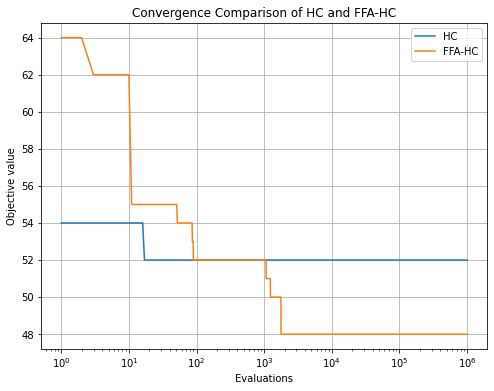

In [26]:
plt.figure(figsize=(8, 6))

plt.plot(iterations, hc_smallest_instance_conv, label='HC')
plt.plot(iterations, ffahc_smallest_instance_conv, label='FFA-HC')

plt.xlabel('Evaluations')
plt.ylabel('Objective value')
plt.title('Convergence Comparison of HC and FFA-HC')
plt.legend()

plt.xscale('log')
plt.grid(True)

plt.show()

In [27]:
hc_convergence = results_df['convergence']
hc_largest_instance_conv = hc_convergence[419]

ffahc_convergence = FFAresults_df['convergence']
ffahc_largest_instance_conv = ffahc_convergence[419]

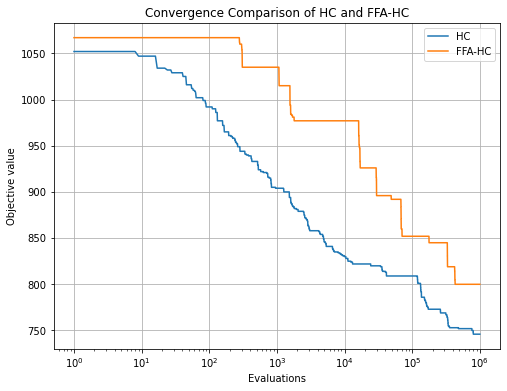

In [28]:
evaluations = range(1, len(hc_smallest_instance_conv) + 1)
plt.figure(figsize=(8, 6))

plt.plot(evaluations, hc_largest_instance_conv, label='HC')
plt.plot(evaluations, ffahc_largest_instance_conv, label='FFA-HC')

plt.xlabel('Evaluations')
plt.ylabel('Objective value')
plt.title('Convergence Comparison of HC and FFA-HC')
plt.legend()

plt.xscale('log')
plt.grid(True)

plt.show()

### Where did HC outperform FFA-HC?

In [29]:
hc_results_winners = results_df[results_df['best_makespan'] < FFAresults_df['best_makespan']]

In [30]:
len(hc_results_winners)

79

In [31]:
hc_results_winners

,instance_id,best_solution,best_makespan,convergence
63,63,"[18, 7, 6, 13, 4, 18, 16, 6, 0, 0, 19, 3, 9, 4...",118,"[182, 182, 182, 182, 169, 169, 169, 164, 164, ..."
95,95,"[16, 4, 21, 19, 2, 3, 17, 0, 11, 20, 17, 19, 1...",228,"[389, 373, 371, 371, 362, 362, 362, 362, 362, ..."
132,132,"[22, 8, 24, 31, 8, 25, 13, 19, 29, 27, 18, 7, ...",249,"[397, 392, 382, 382, 382, 382, 375, 371, 371, ..."
143,143,"[19, 34, 17, 20, 20, 16, 16, 8, 2, 19, 21, 32,...",327,"[478, 478, 478, 478, 478, 478, 478, 478, 478, ..."
159,159,"[12, 27, 9, 37, 36, 23, 15, 11, 14, 39, 33, 9,...",309,"[473, 473, 473, 473, 473, 468, 468, 468, 468, ..."
...,...,...,...,...
414,414,"[99, 53, 29, 0, 91, 70, 62, 15, 94, 1, 19, 27,...",705,"[1014, 1014, 1002, 997, 997, 997, 985, 985, 98..."
415,415,"[0, 12, 51, 48, 22, 63, 29, 60, 92, 87, 66, 6,...",780,"[1095, 1095, 1085, 1085, 1085, 1085, 1085, 108..."
417,417,"[70, 53, 0, 65, 32, 40, 77, 75, 98, 39, 37, 88...",755,"[1200, 1191, 1191, 1182, 1182, 1162, 1162, 116..."
418,418,"[96, 48, 61, 49, 7, 52, 90, 64, 83, 45, 44, 14...",764,"[1150, 1150, 1144, 1144, 1144, 1135, 1135, 113..."


### Where did FFA-HC outperform HC?

In [32]:
ffahc_results_winners = FFAresults_df[FFAresults_df['best_makespan'] < results_df['best_makespan']]

In [33]:
len(ffahc_results_winners)

313

In [34]:
ffahc_results_winners

,instance_id,least_frequent_solution,least_frequent_makespan,best_solution,best_makespan,convergence,search_progression
0,0,"[4, 0, 0, 2, 1, 3, 4, 4, 4, 1, 3, 0, 3, 1, 2, ...",109,"[1, 2, 1, 1, 4, 2, 3, 0, 4, 0, 4, 2, 4, 3, 0, ...",48,"[64, 64, 62, 62, 62, 62, 62, 62, 62, 62, 55, 5...","[64, 64, 62, 62, 62, 68, 69, 69, 69, 81, 55, 5..."
1,1,"[1, 2, 4, 0, 0, 0, 1, 0, 4, 3, 1, 3, 0, 1, 0, ...",100,"[1, 2, 2, 0, 1, 4, 3, 3, 4, 2, 2, 4, 0, 3, 2, ...",48,"[64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 57, 5...","[64, 64, 77, 77, 77, 77, 71, 63, 63, 63, 57, 5..."
2,2,"[1, 4, 4, 1, 3, 2, 4, 0, 1, 3, 0, 2, 2, 0, 1, ...",92,"[0, 2, 4, 3, 1, 1, 2, 3, 0, 0, 4, 3, 0, 2, 1, ...",52,"[80, 80, 80, 80, 80, 76, 76, 68, 68, 68, 60, 6...","[80, 80, 80, 80, 84, 76, 76, 68, 68, 68, 60, 6..."
3,3,"[0, 0, 3, 3, 4, 4, 4, 4, 4, 0, 4, 2, 2, 2, 2, ...",184,"[4, 3, 2, 1, 3, 2, 3, 4, 2, 2, 1, 3, 1, 2, 3, ...",54,"[65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6...","[65, 71, 71, 71, 75, 90, 90, 90, 90, 88, 78, 7..."
4,4,"[4, 3, 3, 1, 4, 1, 0, 0, 0, 0, 3, 2, 3, 0, 0, ...",207,"[0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 3, 4, 0, 1, 3, ...",61,"[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 71, 7...","[82, 82, 99, 96, 96, 96, 106, 106, 97, 91, 71,..."
...,...,...,...,...,...,...,...
403,403,"[62, 94, 53, 25, 71, 36, 35, 79, 0, 72, 96, 6,...",1399,"[56, 92, 59, 94, 39, 61, 2, 44, 55, 43, 41, 20...",611,"[807, 807, 807, 789, 789, 789, 789, 789, 789, ...","[807, 807, 807, 789, 790, 798, 798, 797, 800, ..."
404,404,"[76, 70, 33, 70, 93, 37, 10, 1, 57, 5, 28, 99,...",1079,"[61, 32, 68, 52, 83, 34, 42, 13, 12, 82, 18, 5...",590,"[809, 809, 809, 809, 809, 809, 809, 809, 809, ...","[809, 809, 809, 815, 824, 824, 832, 835, 839, ..."
408,408,"[1, 32, 80, 48, 39, 2, 56, 37, 64, 20, 15, 89,...",2041,"[29, 28, 27, 76, 60, 9, 64, 38, 65, 54, 22, 73...",654,"[978, 978, 978, 978, 978, 978, 978, 978, 978, ...","[978, 989, 983, 983, 983, 983, 992, 1005, 988,..."
413,413,"[57, 63, 11, 40, 62, 91, 64, 59, 88, 45, 69, 4...",2562,"[19, 99, 31, 47, 89, 8, 89, 57, 70, 3, 22, 78,...",702,"[1011, 1011, 1011, 1011, 1011, 1011, 1011, 101...","[1011, 1013, 1020, 1020, 1020, 1025, 1022, 101..."


## Results heatmap

In [35]:
job_shop_df = pd.read_csv('job_shop_data.csv', sep=';', index_col=False)
job_shop_df.head()

,instance_id,num_jobs,num_machines,problem_instance
0,5j5m,5,5,"[[(3, 6), (1, 4), (2, 1), (0, 3), (4, 6)], [(0..."
1,5j6m,5,6,"[[(5, 9), (3, 5), (0, 7), (2, 2), (1, 2), (4, ..."
2,5j7m,5,7,"[[(5, 7), (6, 3), (3, 4), (1, 1), (2, 4), (4, ..."
3,5j8m,5,8,"[[(1, 7), (3, 9), (6, 3), (0, 8), (2, 1), (7, ..."
4,5j9m,5,9,"[[(7, 6), (4, 10), (8, 1), (2, 2), (1, 10), (5..."


In [36]:
job_shop_df['hc_best_makespan'] = results_df['best_makespan']
job_shop_df['ffahc_best_makespan'] = FFAresults_df['best_makespan']
job_shop_df.head()

,instance_id,num_jobs,num_machines,problem_instance,hc_best_makespan,ffahc_best_makespan
0,5j5m,5,5,"[[(3, 6), (1, 4), (2, 1), (0, 3), (4, 6)], [(0...",52,48
1,5j6m,5,6,"[[(5, 9), (3, 5), (0, 7), (2, 2), (1, 2), (4, ...",51,48
2,5j7m,5,7,"[[(5, 7), (6, 3), (3, 4), (1, 1), (2, 4), (4, ...",56,52
3,5j8m,5,8,"[[(1, 7), (3, 9), (6, 3), (0, 8), (2, 1), (7, ...",57,54
4,5j9m,5,9,"[[(7, 6), (4, 10), (8, 1), (2, 2), (1, 10), (5...",82,61


In [37]:
def ffahc_larger(row):
    if row['ffahc_best_makespan'] < row['hc_best_makespan']:
        return 1
    elif row['ffahc_best_makespan'] == row['hc_best_makespan']:
        return 0.5
    else:
        return 0

In [38]:
job_shop_df['ffahc_winner'] = job_shop_df.apply(ffahc_larger, axis=1)

In [39]:
# percentage FFA wins
len(job_shop_df[job_shop_df['ffahc_winner'] == 1.0]) / 420 * 100

74.52380952380952

In [40]:
job_shop_df.head()

,instance_id,num_jobs,num_machines,problem_instance,hc_best_makespan,ffahc_best_makespan,ffahc_winner
0,5j5m,5,5,"[[(3, 6), (1, 4), (2, 1), (0, 3), (4, 6)], [(0...",52,48,1.0
1,5j6m,5,6,"[[(5, 9), (3, 5), (0, 7), (2, 2), (1, 2), (4, ...",51,48,1.0
2,5j7m,5,7,"[[(5, 7), (6, 3), (3, 4), (1, 1), (2, 4), (4, ...",56,52,1.0
3,5j8m,5,8,"[[(1, 7), (3, 9), (6, 3), (0, 8), (2, 1), (7, ...",57,54,1.0
4,5j9m,5,9,"[[(7, 6), (4, 10), (8, 1), (2, 2), (1, 10), (5...",82,61,1.0


In [41]:
heatmap_pivot = pd.DataFrame()
heatmap_pivot['num_jobs'] = job_shop_df['num_jobs']
heatmap_pivot['num_machines'] = job_shop_df['num_machines']
heatmap_pivot['ffahc_winner'] = job_shop_df['ffahc_winner']
heatmap_pivot = heatmap_pivot.pivot('num_jobs', 'num_machines', 'ffahc_winner')
heatmap_pivot =heatmap_pivot.iloc[::-1]
heatmap_pivot

num_machines,5,6,7,8,9,10,11,12,13,14,...,16,17,18,19,20,21,22,23,24,25
num_jobs,,,,,,,,,,,,,,,,,,,,,
100,0.5,1.0,1.0,1.0,1.0,1.0,0.0,0.5,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
95,0.5,1.0,0.5,0.5,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
90,1.0,0.5,0.5,0.5,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
85,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
80,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
70,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
65,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
60,0.5,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


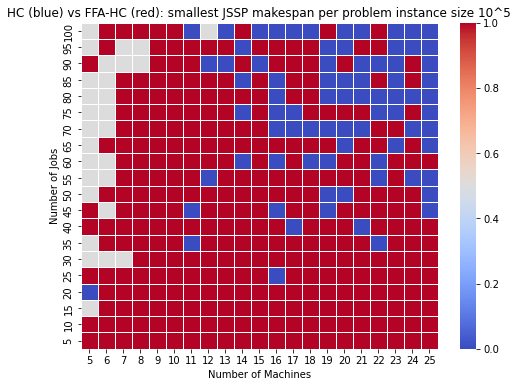

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_pivot, annot=False, cmap='coolwarm', linewidths=1)

# Add labels and title
plt.xlabel('Number of Machines')
plt.ylabel('Number of Jobs')
plt.title('HC (blue) vs FFA-HC (red): smallest JSSP makespan per problem instance size 10^5')

# Display the heatmap
plt.show()